In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

C:\Users\pulzara\AppData\Local\Temp\ipykernel_14740\495279268.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from fbprophet import Prophet
from neuralprophet import NeuralProphet 

import random
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
import math 
import random
import miceforest as mf
import sys 
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from fbprophet import Prophet
from neuralprophet import NeuralProphet 

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)


import gc

In [3]:
df_imputed = pd.read_table('C:/Users/pulzara/Documents/Universidad internacional de valencia/TFM/base de datos/SIMAC organizados/BD2/data_imputed_rf.txt',delimiter = '|') 

In [4]:
data = pd.read_table('C:/Users/pulzara/Documents/Universidad internacional de valencia/TFM/base de datos/SIMAC organizados/BD2/data.txt',delimiter = '|') 

In [5]:
data = data[["Fecha","Hora","Temperatura","Velocidad","Presion","Humedad","Precipitacion","Radiacion", "Estacion"]]
data.head(3) 

,Fecha,Hora,Temperatura,Velocidad,Presion,Humedad,Precipitacion,Radiacion,Estacion
0,2017-01-01,0:00:53,18.06,1.79,603.13,84.0,35.8,0.0,alcazares
1,2017-01-01,0:06:00,18.06,2.24,603.16,84.0,35.8,0.0,alcazares
2,2017-01-01,0:11:05,18.06,0.89,603.16,84.0,35.8,0.0,alcazares


In [6]:
df_imputed = df_imputed.drop(df_imputed.columns[[0,1,8]], axis = 1) 

In [7]:
data["Hora"] = pd.to_datetime(data["Fecha"] + ' '+ data["Hora"])  

In [8]:
df_imputed.insert(loc =0,column='Fecha', value = data.Fecha)     
df_imputed.insert(loc =7,column='Estacion', value = data.Estacion) 
df_imputed.insert(loc =7,column='Hora', value = data.Hora) 

In [9]:
df_imputed = df_imputed.drop(df_imputed.columns[[9,10,11]], axis = 1)

In [10]:
df_imputed["Velocidad"] = np.where((df_imputed.Velocidad < 0), 0, df_imputed["Velocidad"])  

In [11]:
def group(data, column_name, frec):

        """
        Esta funcion agrupa por serie de tiempo en dias para obtener la media los datos
        """
        data = data.groupby([pd.Grouper(key=column_name, freq=frec)]).mean() 
        data = data.reset_index()
        data[column_name] = pd.to_datetime(data[column_name]) 
        data[column_name] = data[column_name].sort_values(ascending=False)
        data = data.set_index(column_name)

        return data

In [12]:
df = df_imputed.copy() 

In [13]:
df["Hora"] = df["Hora"].astype(str).str[:-2]   
df["Hora"] = df["Hora"] + '00'

In [14]:
df["Hora"] = pd.to_datetime(df["Hora"]) 

In [15]:
tipos = df.Estacion.unique()
tipos 

array(['alcazares', 'aranjuez', 'bosques_del_norte', 'chec_uribe',
       'el_carmen', 'emas', 'hospital_caldas', 'la_nubia', 'la_palma',
       'milan', 'obs_vulcanologico', 'posgrados', 'yarumos'], dtype=object)

In [16]:
holidays = pd.DataFrame({
                'holiday': 'eventosmanizales', 
                'ds': pd.to_datetime(['2017-04-19','2011-04-13','2011-11-05']),
                'lower_window': 0,
                'upper_window': 1,
            })
holidays

,holiday,ds,lower_window,upper_window
0,eventosmanizales,2017-04-19,0,1
1,eventosmanizales,2011-04-13,0,1
2,eventosmanizales,2011-11-05,0,1


Estacion : alcazares


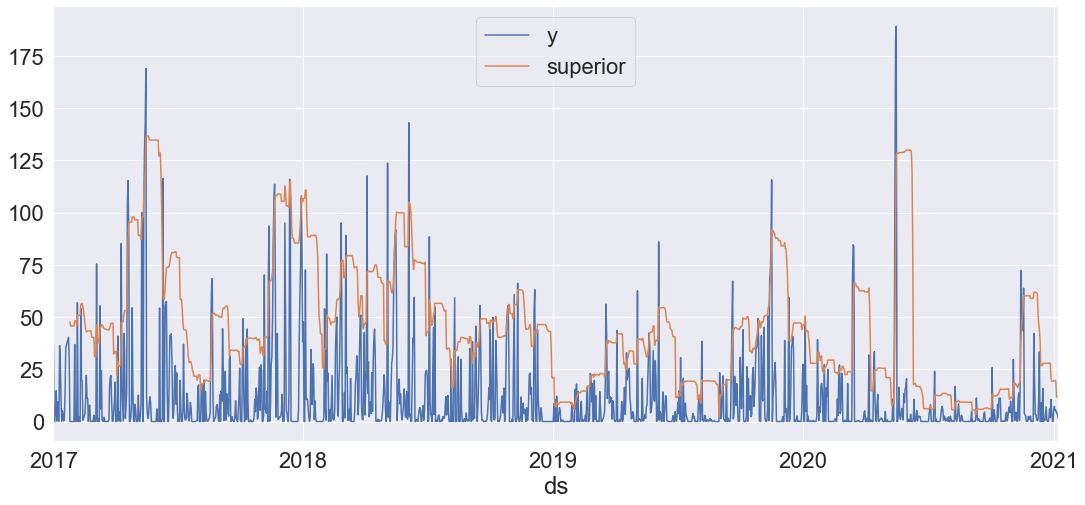

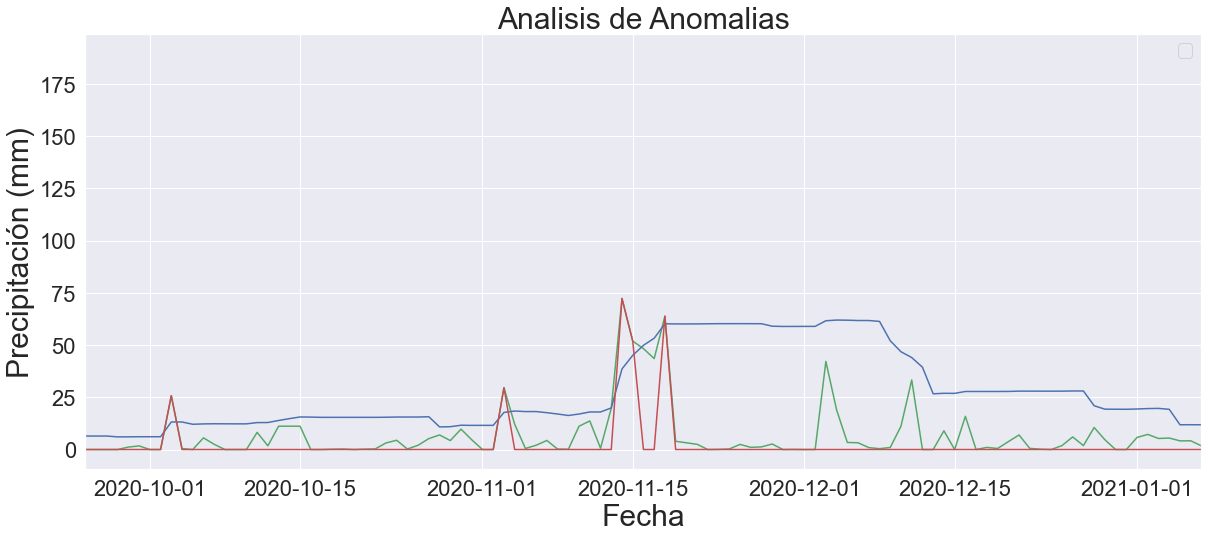

Estacion : aranjuez


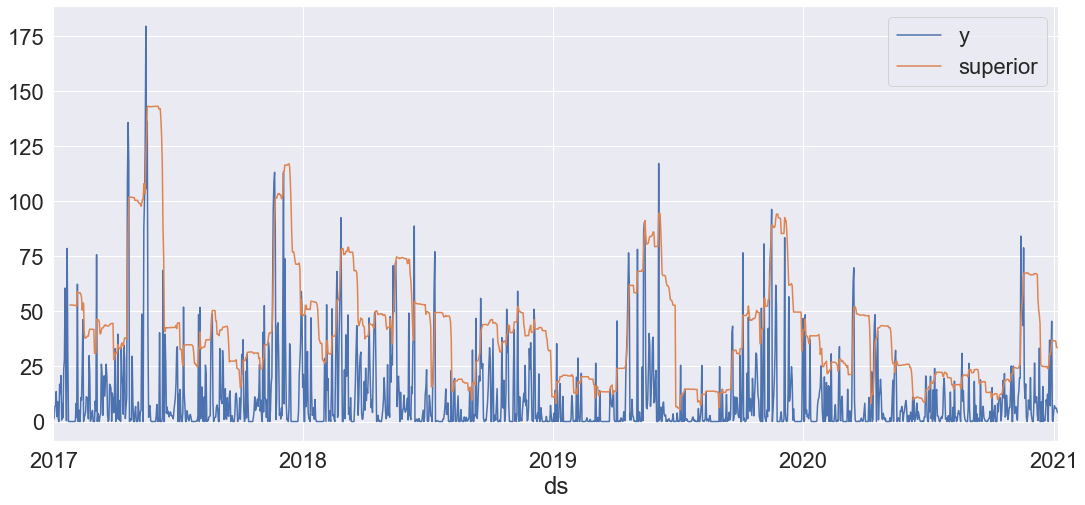

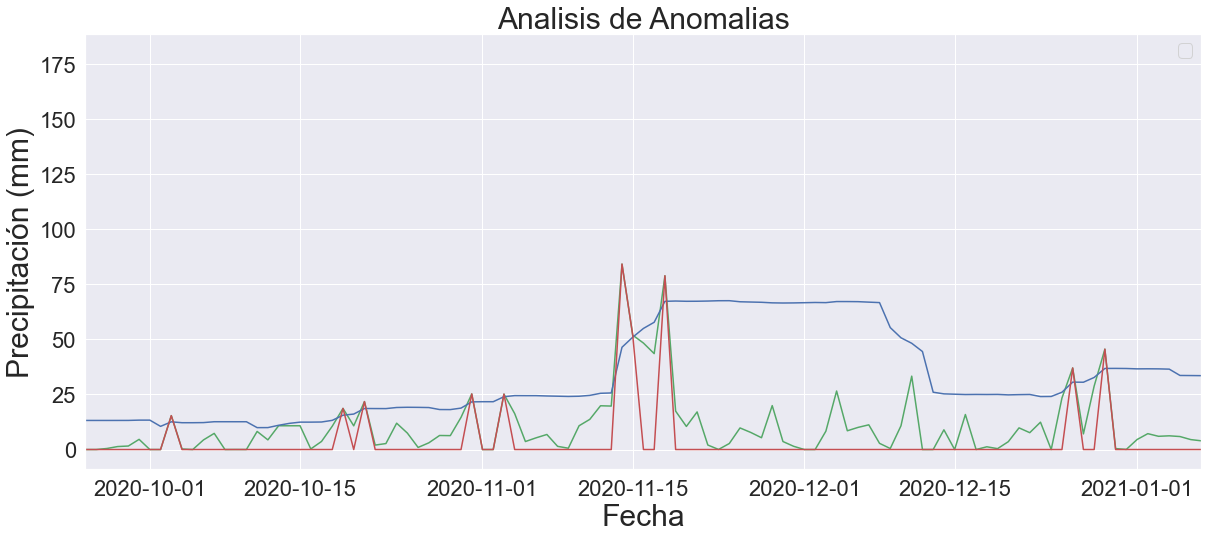

Estacion : bosques_del_norte


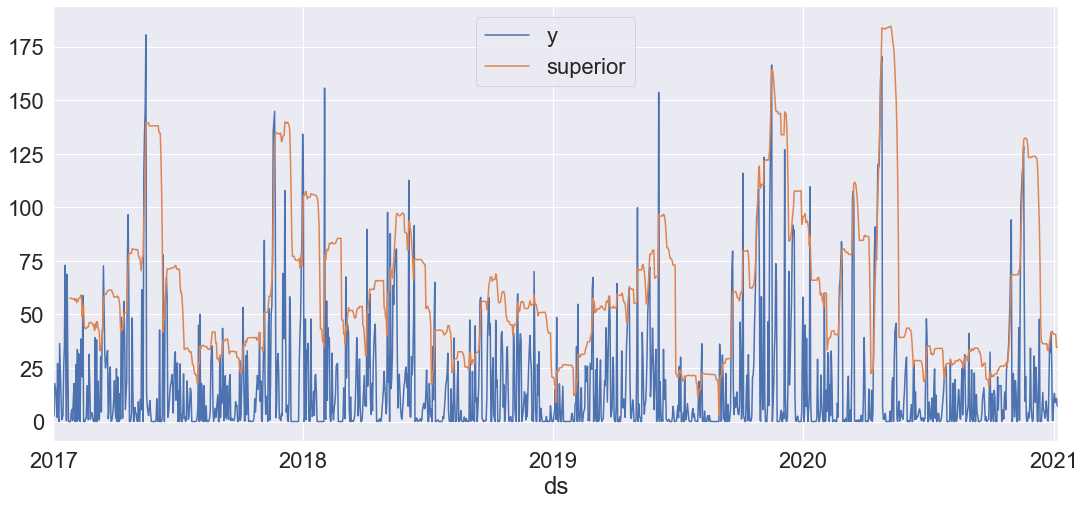

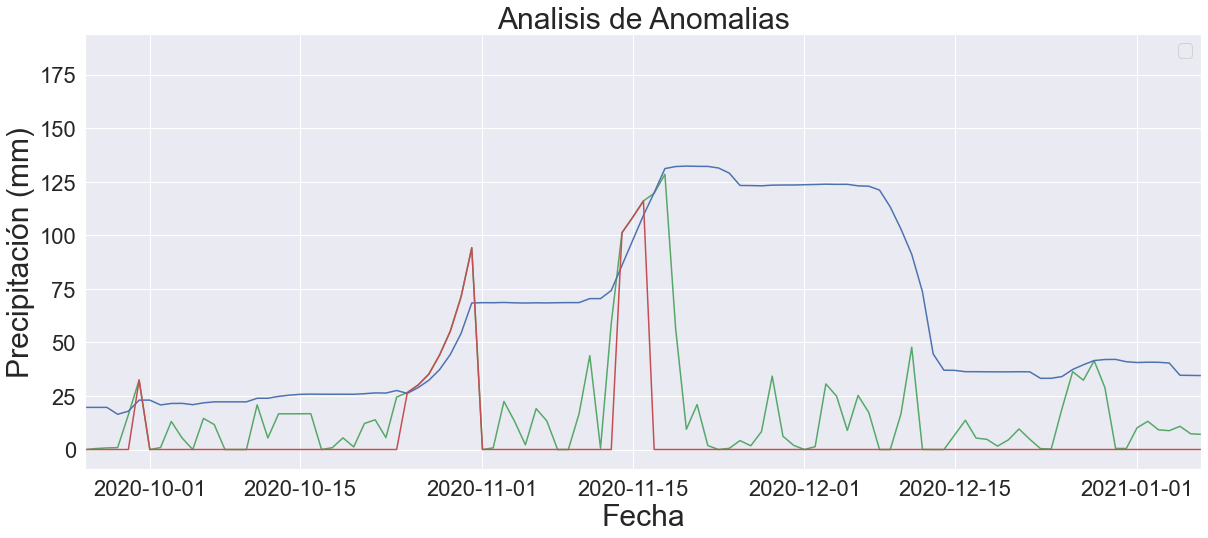

Estacion : chec_uribe


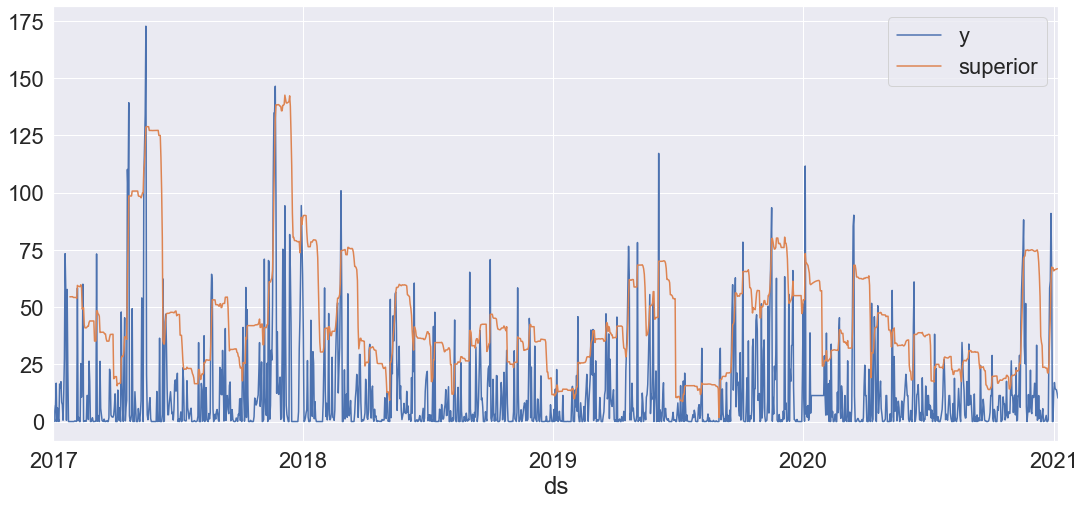

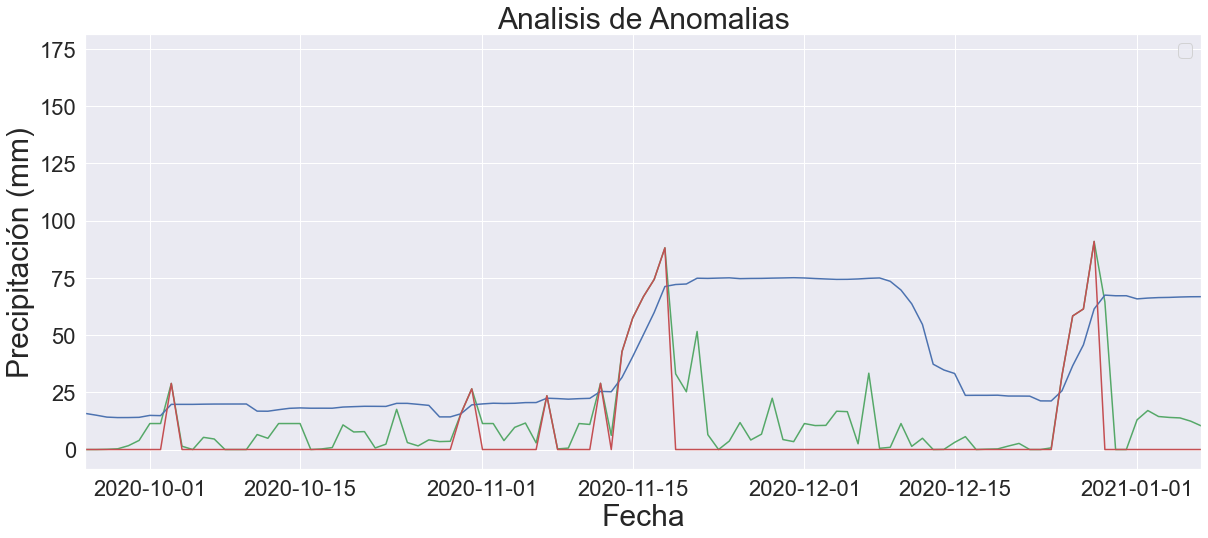

Estacion : el_carmen


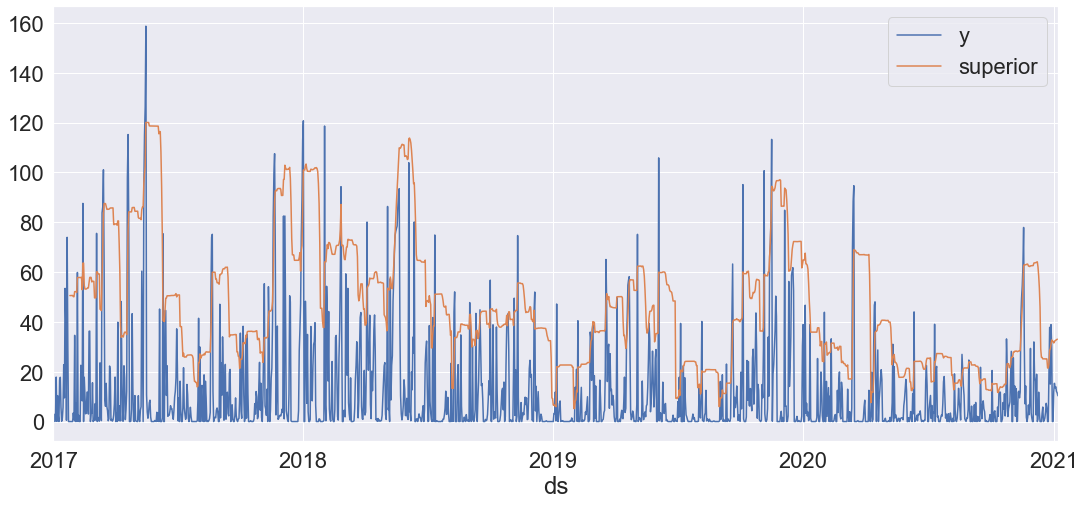

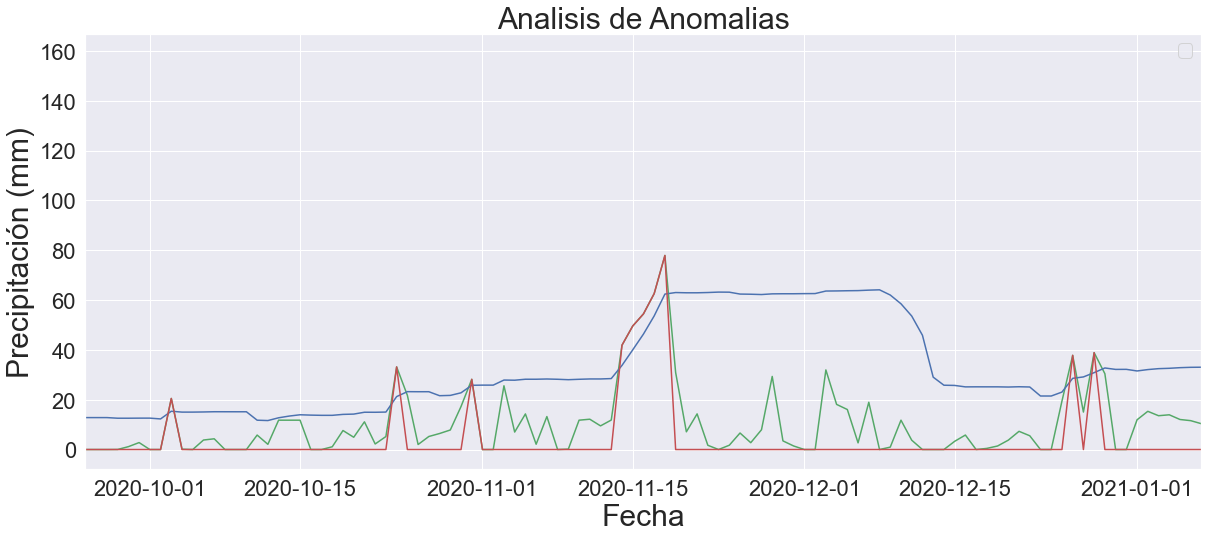

Estacion : emas


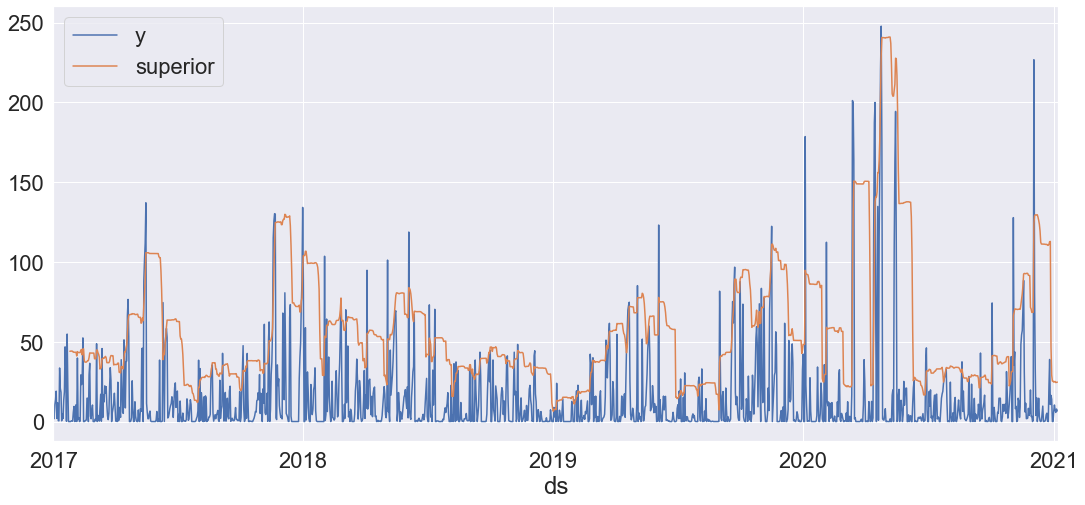

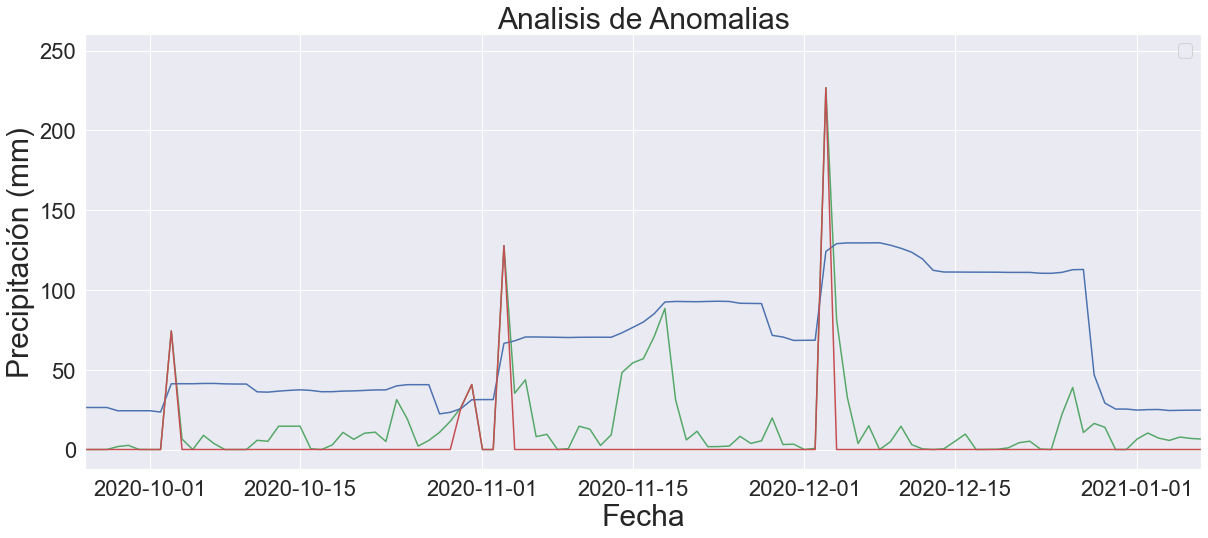

Estacion : hospital_caldas


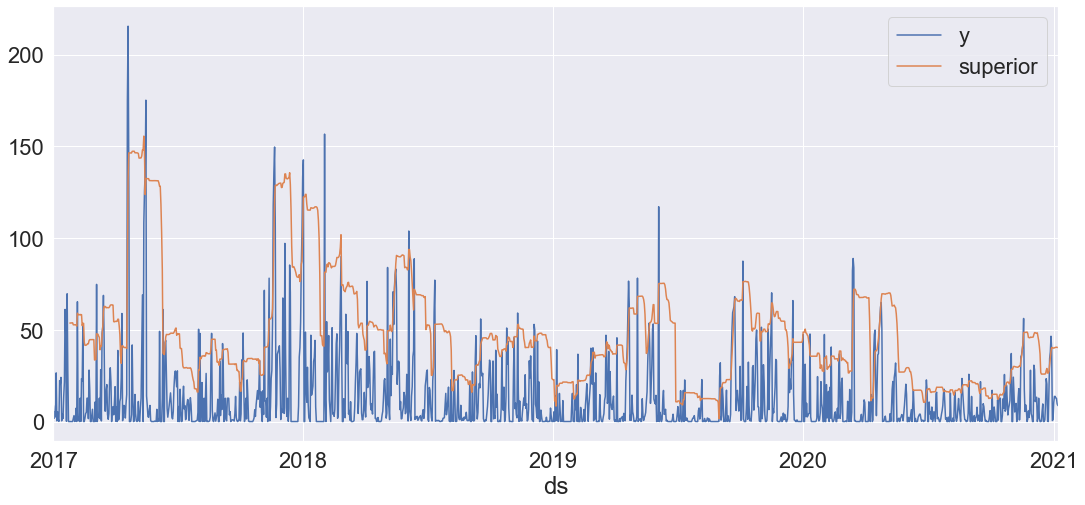

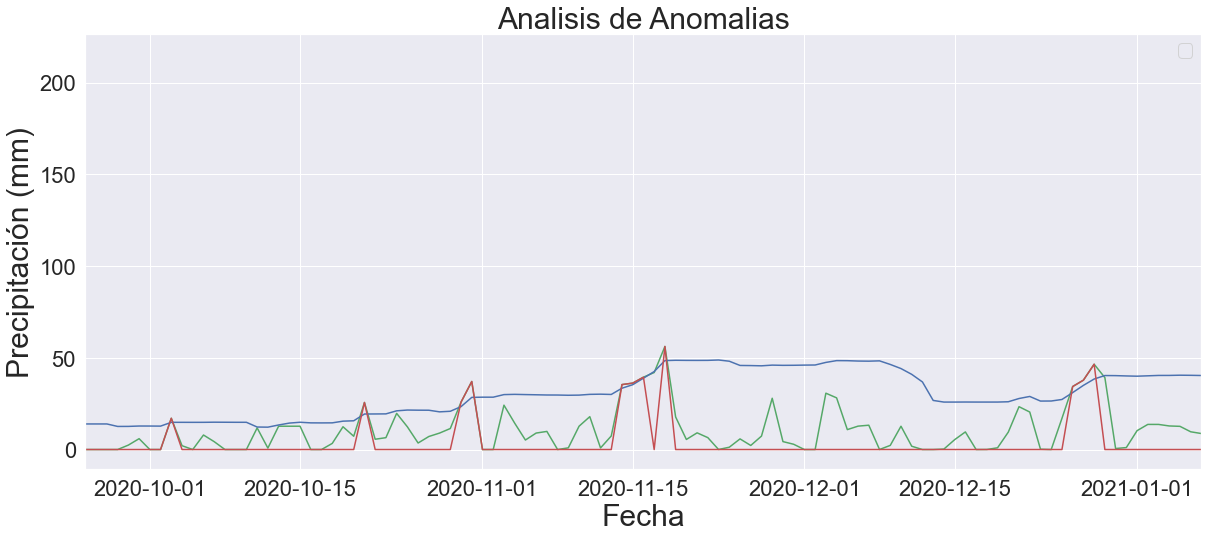

Estacion : la_nubia


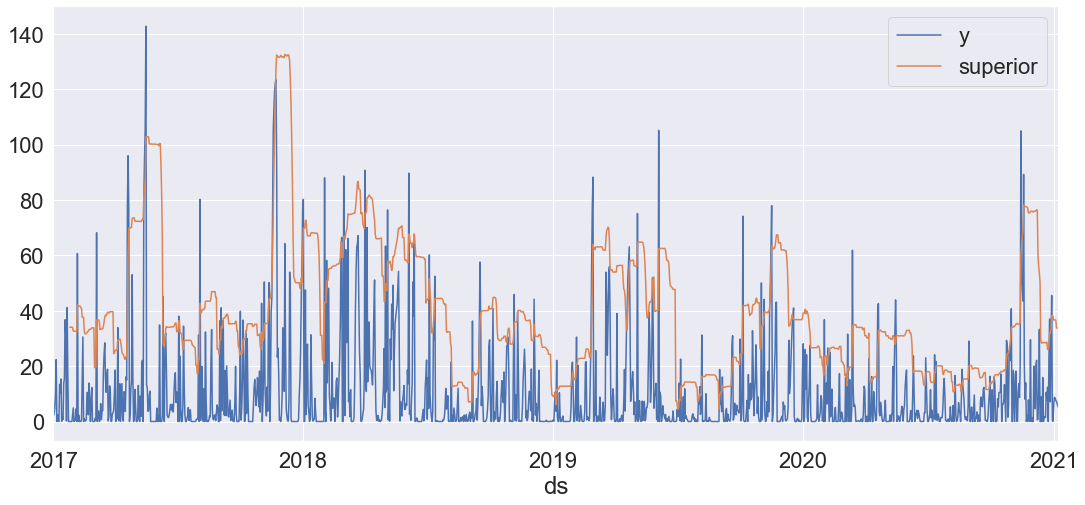

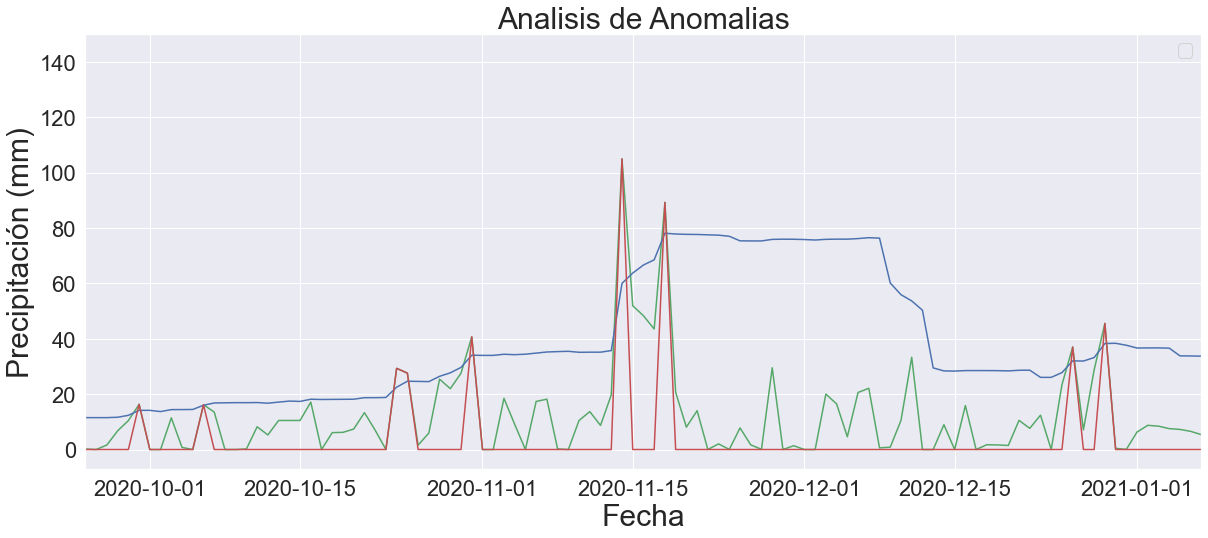

Estacion : la_palma


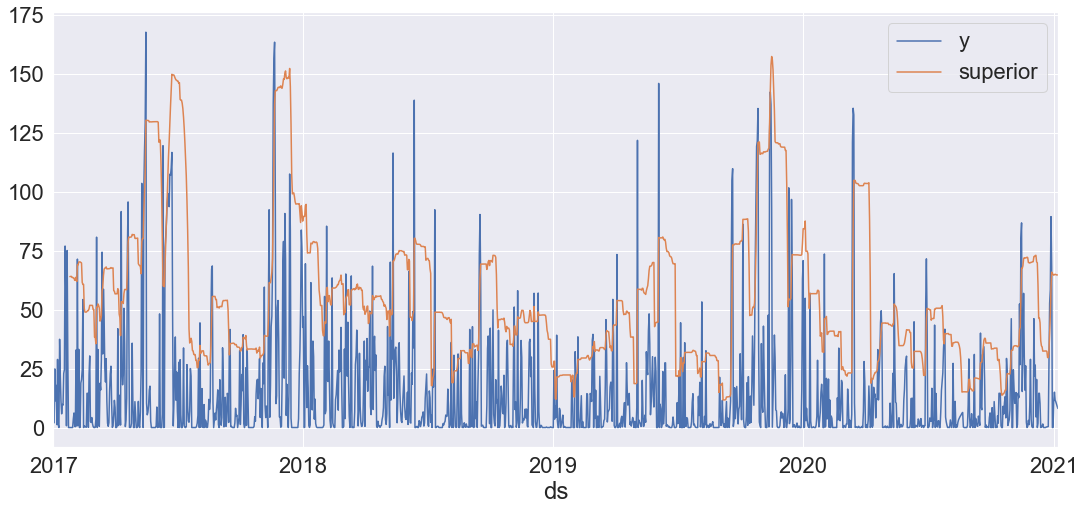

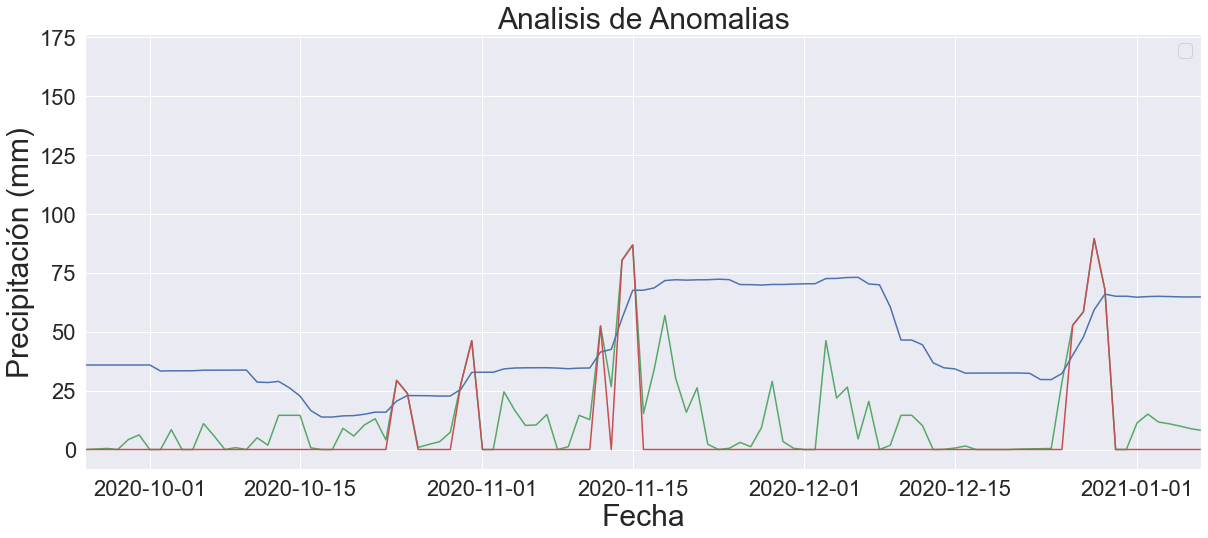

Estacion : milan


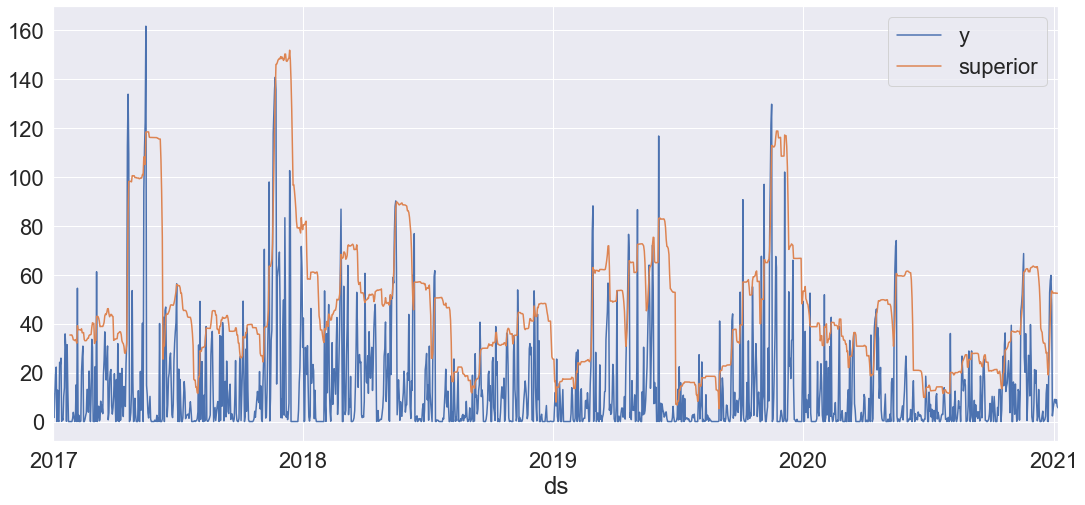

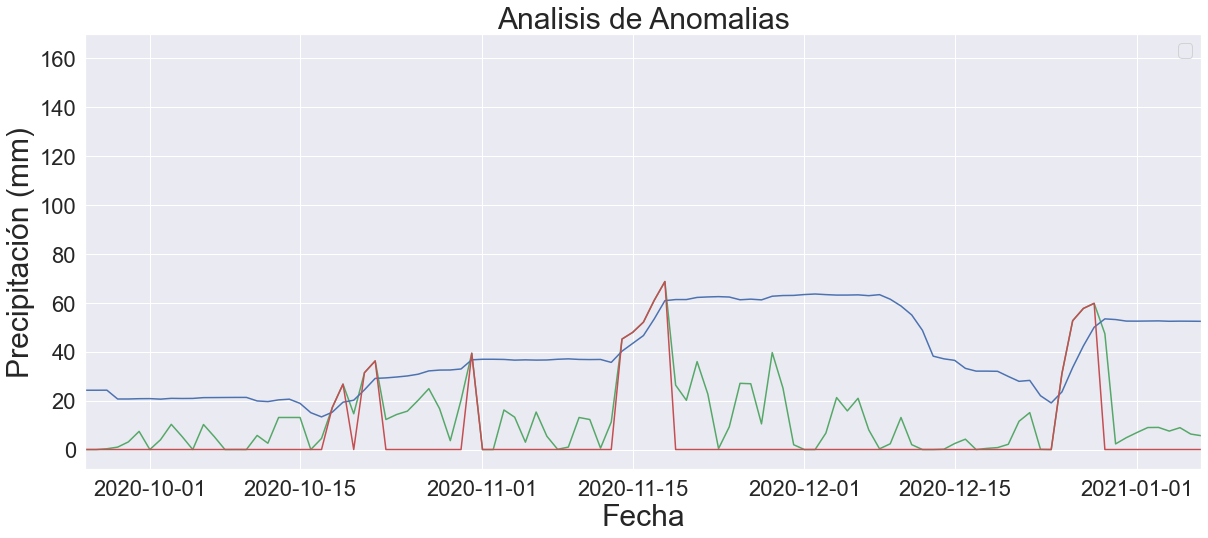

Estacion : obs_vulcanologico


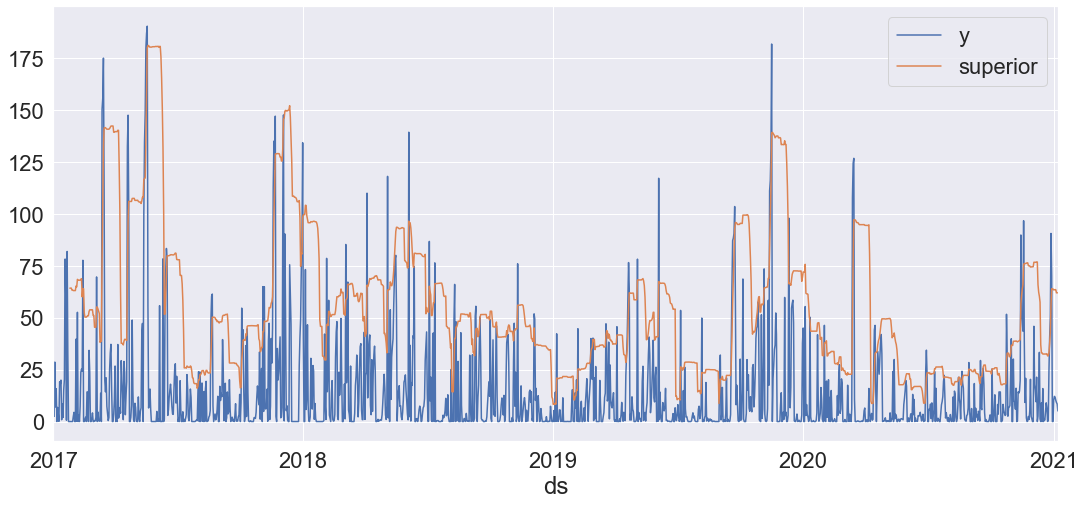

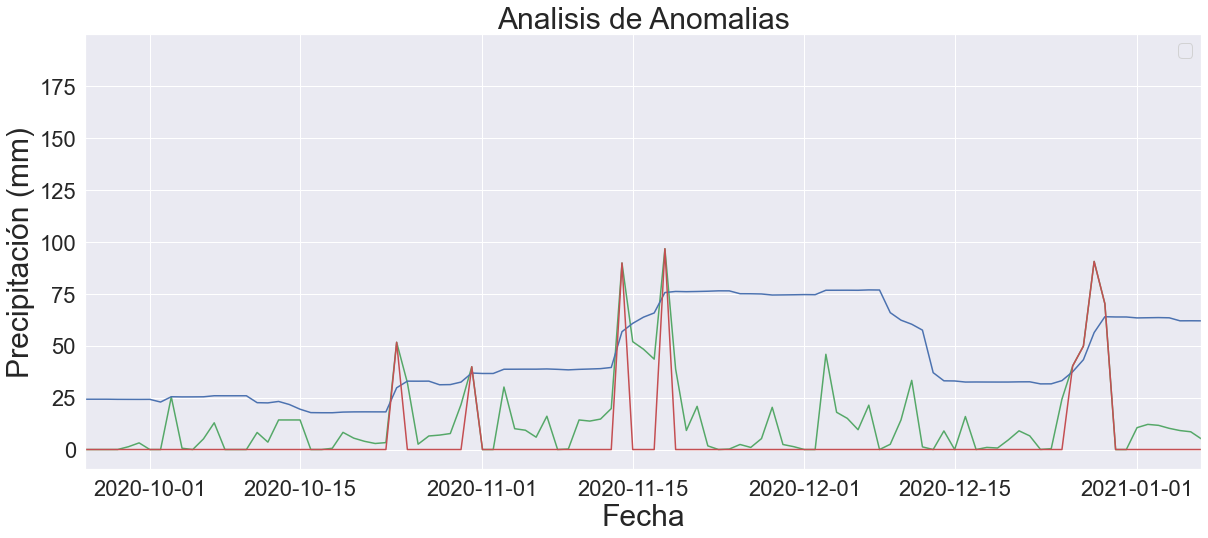

Estacion : posgrados


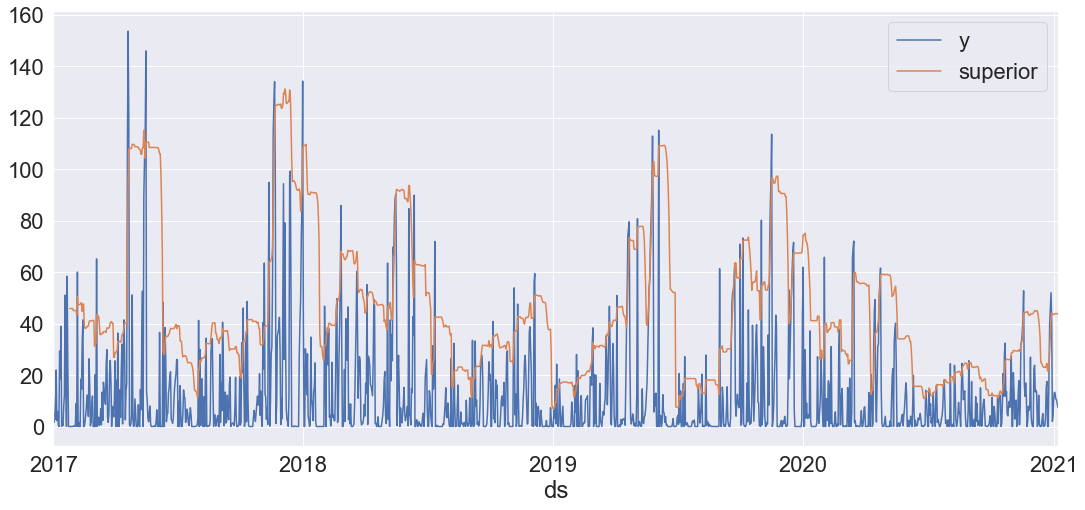

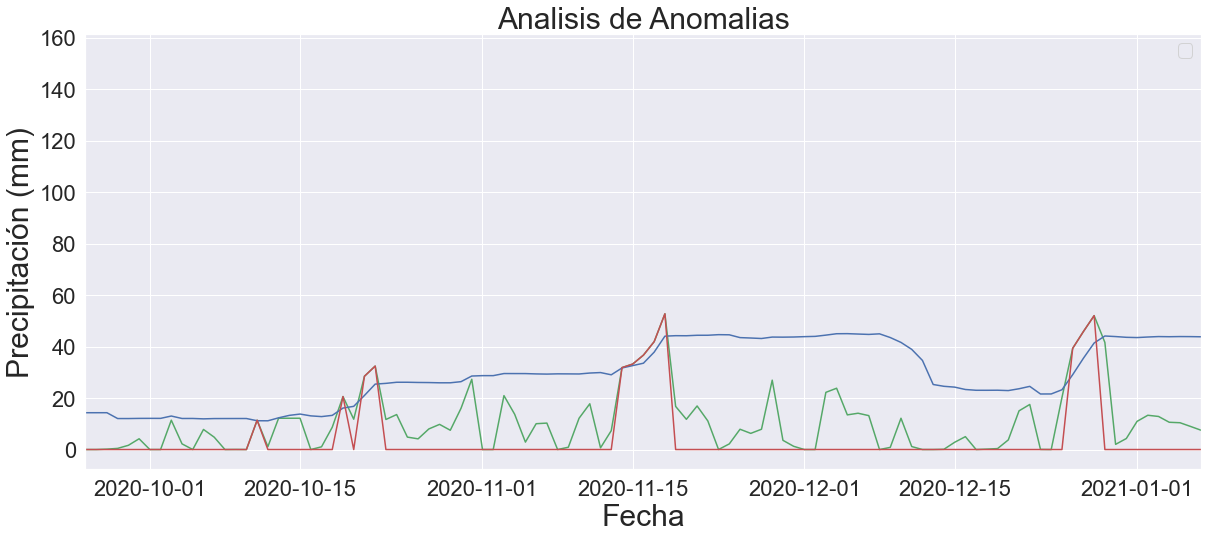

Estacion : yarumos


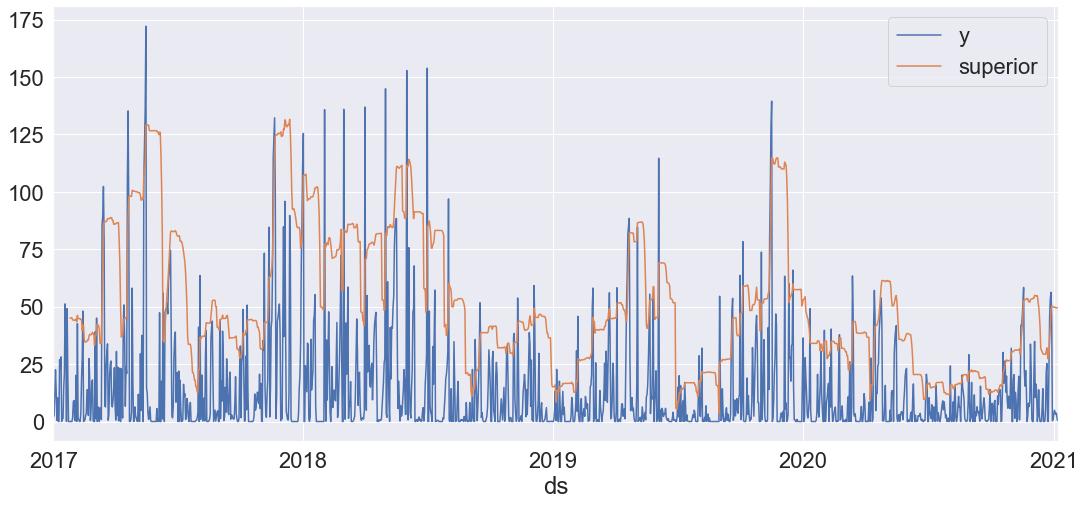

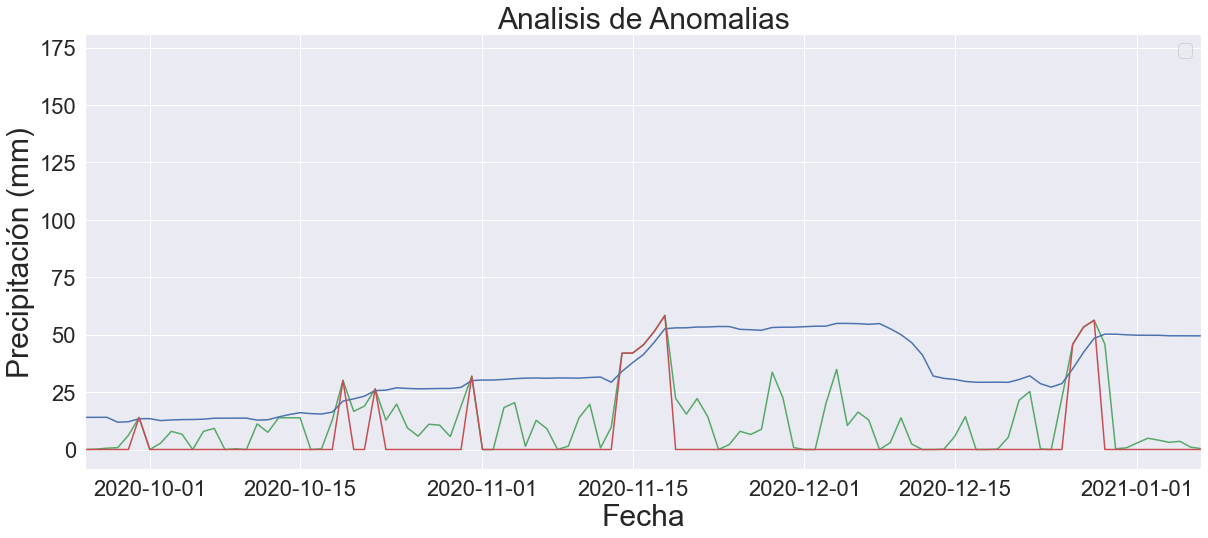

In [136]:
import datetime 
guardar = []
for i in tipos:
    print("Estacion :", i)
    df_1 = df[df.Estacion == i] 
    df_1 = group(df_1,"Hora", frec="1D")
    df_1["Estacion"] = i
    #Rellenamos los valores nulls con la media
    df_1 = df_1.fillna(df_1.mean()) 

    df2 = df_1[["Precipitacion","Temperatura", 'Velocidad','Presion','Humedad','Radiacion']]  
    df2.reset_index(drop = False, inplace = True)
    df2 = df2.rename(columns={"Precipitacion":"y", "Hora": "ds"})
    
    
    m = Prophet(interval_width=0.95, daily_seasonality=True, holidays = holidays) 
    m.add_regressor('Temperatura')
    m.add_regressor('Presion') 
    m.add_regressor('Velocidad')
    m.add_regressor('Humedad')
    m.add_regressor('Radiacion')
    m.fit(df2) 
    
    futur = m.make_future_dataframe(periods=7, freq="1D") 
    future_train = futur.iloc[:-14] 
    future  = futur.iloc[-31:]   
    
    future_train.reset_index(inplace = True, drop = True)
    future.reset_index(inplace = True, drop = True)
    
    future_train = pd.merge(future_train ,df2[["Temperatura", 'Velocidad','Presion','Humedad','Radiacion',"ds"]].iloc[:-7], how = "left", on = ['ds'])
    future_train = future_train.fillna(df_1.mean()) 
    
    
    future = pd.merge(future,df2[["Temperatura", 'Velocidad','Presion','Humedad','Radiacion',"ds"]].iloc[-24:], how = "left", on = ['ds'])
    future = future.fillna(df_1.mean()) 
    
    
    forecast_train = m.predict(future_train) 
    forecast = m.predict(future)
    
    
    forecast2 = forecast.copy()
    forecast2.rename(columns={'yhat':'y'},inplace = True) 

    frames = [df2, forecast2[['ds','y','Temperatura','Velocidad','Presion','Humedad','Radiacion']].iloc[-7:]] 
    final = pd.concat(frames).reset_index(drop = True)

    data  = final[['ds','y']] 
    data.set_index('ds', inplace=True, drop = True)  
    data 

    wind = 25
    sigma = 2 

    data["superior"] = data["y"].rolling(window=wind)\
        .mean() + (sigma * data["y"].rolling(window=wind).std())
    data.plot(figsize=(18,8)) 

    data["anomalia"] = data.apply(
        lambda row: row[0] if (row[0]>=row["superior"]) else 0, axis=1)


    plt.figure(figsize=(20,8))   
    sns.set(font_scale = 2)
    plt.plot(data.y, 'g-')   
    plt.plot(data.superior, 'b-') 
    plt.plot(data.anomalia, 'r-')   
    plt.xlim(datetime.datetime(2020,9,25), datetime.datetime(2021,1,7)) 
    plt.title('Analisis de Anomalias', fontsize=30)       
    plt.legend(['y','Superior','anomalia'], prop={'size': 13})    
    plt.xlabel('Fecha', fontsize = 30)    
    plt.ylabel("Precipitación (mm)",fontsize = 30)    
    plt.legend(loc = 1,prop={'size': 18}) 
    plt.show() 